# Use Fastai to label images containing CSpine

There are extra slices above and below the cspine which don't contribute to predictions. It would be helpful to only focus on the pertinent images.

In [1]:
! pip install pylibjpeg -q
! pip install python-gdcm -q
! pip install pylibjpeg-libjpeg -q

## Libraries

In [2]:
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastcore.all import *

import pandas as pd
import pydicom
import numpy as np

import matplotlib.image as mpimg
import cv2
import nibabel as nib

from tqdm.auto import tqdm

## Gather .csv files

In [3]:
root = Path('../input/rsna-2022-cervical-spine-fracture-detection')
train_folder = root/'train_images'
test_folder = root/'test_images'

seg_folder = root/'segmentations'
segmentations = list(seg_folder.iterdir())
seg_ids = [o.stem for o in segmentations]

train_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
test_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/test.csv")
bbdf = pd.read_csv('../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv')

train_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


## Load segmentation files and get top and bottom slices with CSpine labels

### CSpine labels are 1-8, 0 is background

In [4]:
def get_index_boundaries(study_id):
    seg = nib.load(seg_folder/(study_id + '.nii')).get_fdata()
    c = {1., 2., 3., 4., 5., 6., 7.}
    last = 0
    first = 100000
    count = seg.shape[2]
    for i in range(count):
        arr = seg[:,:,i]
        rowvals = set(np.unique(arr))
        if len(c.intersection(rowvals)) > 0:
            if i < first:
                first = i
            if i > last:
                last = i
    return first, last, count        
            
def get_slice_boundaries_from_sag(study_id):
    seg = nib.load(seg_folder/(study_id + '.nii')).get_fdata()
    c = {1., 2., 3., 4., 5., 6., 7.}
    n=16
    spread=160
    thickness = int(spread/n)
    slice = int(seg.shape[0]/2 - spread/2)

    max = 0
    min = 100000
    for i in range(n):
        #use first dimension to get sagittal views
        arr = seg[slice + (i*thickness),:,:]
        #flip and rotate so that C1 is at the top
        arr = np.flip(arr, 0)
        arr = np.rot90(arr)
        vals = set(np.unique(arr))
        if (c.intersection(vals) == c):
            #ignore first and last slice because of issues with '1.2.826.0.1.3680043.1363'
            for i in range(1, arr.shape[0] - 1):
                row = arr[i]
                rowvals = set(np.unique(row))
                if len(c.intersection(rowvals)) > 0:
                    if i > max:
                        max = i
                    if i < min:
                        min = i
    return (min, max, seg.shape)

## Create a dataframe of the max and min slices containing any cspine label

### Slices above the cspine are labeled 'head' and below are labeled 'tspine'

In [5]:
def get_sorted_fns(study_path):
    files = []
    fns = get_dicom_files(study_path)   
    fn_position_dict = {}
    for fn in fns:
        ds = pydicom.dcmread(fn, stop_before_pixels = True)
        fn_position_dict[fn.stem] = ds.ImagePositionPatient[2]
        files.append(ds)
    
    #sort reverse to get head first, the z-axis is increasing towards the cranial (as opposed to caudal) end of the patient for the neck
    fn_position_dict = {key: val for key, val in sorted(fn_position_dict.items(), key = lambda ele: ele[1],reverse=True)}
    sorted_fns = list(fn_position_dict.keys())
     #returns list of image names sorted by patient position   
    return sorted_fns

def process_seg(seg_ids):
    dict_for_df = []

    for study_id in tqdm(seg_ids):
        min, max, shape = get_slice_boundaries_from_sag(study_id)
        fns = get_sorted_fns(train_folder/study_id)
        fns = [train_folder/study_id/(o + '.dcm') for o in fns]
        
        #ignore first and last slice because of issues with '1.2.826.0.1.3680043.1363'
        for i in range (1,shape[2]-1):
            label = 'cspine'
            if i < min:
                label = 'head'
            elif i > max:
                label = 'tspine'
            fn = Path(fns[i])
            row = {'study_id':study_id, 'slice':fn.stem,'label':label }
            dict_for_df.append(row)

    df = pd.DataFrame(dict_for_df)
    return df


if Path('../input/cspine-data/spine_labels.csv').exists():
    df = pd.read_csv('../input/cspine-data/spine_labels.csv')
else:
    df = process_seg(seg_ids)
    df.to_csv('spine_labels.csv', index=False)
df.head()

,study_id,slice,label
0,1.2.826.0.1.3680043.780,2,head
1,1.2.826.0.1.3680043.780,3,head
2,1.2.826.0.1.3680043.780,4,head
3,1.2.826.0.1.3680043.780,5,head
4,1.2.826.0.1.3680043.780,6,head


In [6]:
df.label.value_counts()

cspine    19077
tspine     5847
head       4734
Name: label, dtype: int64

In [7]:
def get_fn(study_id, slice):
    return train_folder/study_id/f'{slice}.dcm'

## Modified Fastai PILDicom class to get around mode errors

In [8]:
#PILDicom2 adapted from https://forums.fast.ai/t/fastai2-problems-with-medical-images-dicom/76138/4 by @deep_derping
class PILDicom2(PILBase):
    "same as PILDicom but changed pixel type  as np.int16 cannot be handled by PIL"
    _open_args,_tensor_cls,_show_args = {},TensorDicom,TensorDicom._show_args
    @classmethod
    def create(cls, fn:(Path,str,bytes), mode=None)->None:
        "Open a `DICOM file` from path `fn` or bytes `fn` and load it as a `PIL Image`"
        if isinstance(fn,bytes): im = Image.fromarray(dcmread_to8bit(pydicom.filebase.DicomBytesIO(fn)))
        if isinstance(fn,(Path,str)): im = Image.fromarray(dcmread_to8bit(fn))
        im.load()
        im = im._new(im.im)
        return cls(im.convert(mode) if mode else im)
    

def get_window_from_dicom(dcm, default = (2000, 500)):
    """
    Returns window width and window center values or first example if MultiValue
    Strips comma from value if present (seen in a different dataset)
    If no window width/level is provided or available, returns default.
    """
    width, level = default

    if "WindowWidth" in dcm:
        width = dcm.WindowWidth
        if isinstance(width, pydicom.multival.MultiValue):
            width = float(width[0])
        else:
            width = float(str(width).replace(',', ''))

    if "WindowCenter" in dcm:
        level = dcm.WindowCenter
        if isinstance(level, pydicom.multival.MultiValue):
            level = float(level[0])
        else:
            level = float(str(level).replace(',', ''))
            
    return width, level

# apply slope/intercept and W/L
def dcmread_to8bit(fn):
    dcm = fn.dcmread()
    arr=dcm.pixel_array
    
    #slope, intercept
    slope = 1
    intercept = 0
    if "RescaleIntercept" in dcm and "RescaleSlope" in dcm:
        intercept = int(dcm.RescaleIntercept)
        slope = int(dcm.RescaleSlope)
        
    arr = intercept + arr * slope
    
    #window
    width,level = get_window_from_dicom(dcm)
    if width is not None and level is not None:
        arr = np.clip(arr, level - width // 2, level + width // 2)
        
    #scale
    arr = (arr - np.min(arr)) / np.max(arr)
    arr = (arr * 255).astype("uint8")
    
    if "PhotometricInterpretation" in dcm and dcm.PhotometricInterpretation == "MONOCHROME1":
        arr = 255 - arr
        
    return arr

## Fastai datablock

In [9]:
datablock = DataBlock(blocks=(ImageBlock(cls=PILDicom2), CategoryBlock),
                   get_x=lambda x:train_folder/x[0]/f'{x[1]}.dcm',
                   get_y=lambda x:x[-1],
                   item_tfms=[Resize(224)],
                   batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)])

dls = datablock.dataloaders(df.values, num_workers=4)
dls.vocab

['cspine', 'head', 'tspine']

## Fastai vision_learner

In [10]:
learn = vision_learner(dls, resnet34, metrics=accuracy).to_fp16()
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.256701,0.119163,0.954982,06:33


epoch,train_loss,valid_loss,accuracy,time
0,0.080449,0.042969,0.983308,06:28
1,0.085634,0.078100,0.977070,06:22
2,0.074189,0.048942,0.983645,06:19
3,0.056779,0.039851,0.985331,06:16
4,0.033729,0.044923,0.987692,06:12
5,0.029282,0.025422,0.992244,06:19
6,0.021840,0.032057,0.989041,06:17
7,0.011652,0.021968,0.993930,06:11
8,0.008258,0.020990,0.994099,06:11
9,0.006907,0.021738,0.994099,06:15


## Save model

In [11]:
learn.save('spine_label.h5')

Path('models/spine_label.h5.pth')

In [12]:
# !mkdir  'models'
# !cp  '../input/cspine-data/spine_label.h5.pth' 'models'

In [13]:
# learn.load('spine_label.h5')

In [14]:
#learn.show_results(max_n=16)

In [15]:
# interp = Interpretation.from_learner(learn)
# interp.plot_top_losses(2)

## Create dataframe of the remaining training images for prediction

In [16]:
#get all image names
csv = Path('../input/cspine-data/dcm_filenames.csv')
if csv.exists():
    fndf = pd.read_csv('../input/cspine-data/dcm_filenames.csv')
else:
    fn_glob = train_folder.glob('**/*.dcm')
    fns = [fn for fn in fn_glob]
    fndf = pd.DataFrame({'fn':fns})
    fndf.to_csv('dcm_filenames.csv', index=False)

fndf['study_id'] = fndf.fn.apply(lambda x: Path(x).parent.name)
fndf['slice'] = fndf.fn.apply(lambda x: Path(x).stem)
fndf = fndf.drop('fn', axis=1)
fndf.slice = fndf.slice.astype(int)
fndf = fndf.sort_values(by = ['study_id', 'slice'])
fndf.head()

,study_id,slice
39331,1.2.826.0.1.3680043.10001,1
39334,1.2.826.0.1.3680043.10001,2
39457,1.2.826.0.1.3680043.10001,3
39389,1.2.826.0.1.3680043.10001,4
39386,1.2.826.0.1.3680043.10001,5


## List of images in study at intervals of 50/count. Take first and last 12.

This assumes that the central 50% of the volume includes CSpine and make predictions on the front and back 25%.

In [17]:
def get_indices(count):
    step = max(int(count/50), 1)
    arr = np.arange(1,count,step)
    retarr = arr[:12].copy()
    retarr = np.append(retarr, arr[-12:])
    return retarr

def get_indices_for_pred(group):
    count = group.shape[0]
    indices = get_indices(count)
    ret = [o in indices for o in range(count)]
    return ret

fndf['should_predict'] = fndf.groupby('study_id').transform(get_indices_for_pred)
fndf.head()

,study_id,slice,should_predict
39331,1.2.826.0.1.3680043.10001,1,False
39334,1.2.826.0.1.3680043.10001,2,True
39457,1.2.826.0.1.3680043.10001,3,False
39389,1.2.826.0.1.3680043.10001,4,False
39386,1.2.826.0.1.3680043.10001,5,False


## Only predict on images not in segmentation group

In [18]:
train_ids = train_df.StudyInstanceUID.unique()
study_ids = list(set(train_ids) - set(seg_ids))

tdf = fndf[(fndf.should_predict == True) & (fndf.study_id.isin(study_ids))]
tdf = tdf[['study_id','slice']]
tdf.head()

,study_id,slice
39334,1.2.826.0.1.3680043.10001,2
39357,1.2.826.0.1.3680043.10001,7
39212,1.2.826.0.1.3680043.10001,12
39327,1.2.826.0.1.3680043.10001,17
39228,1.2.826.0.1.3680043.10001,22


In [19]:
tdf.to_csv('nonseg_image_paths.csv', index = False)

## Predict

In [20]:
test_dl = learn.dls.test_dl(tdf.values, num_workers=1)
preds,_ = learn.get_preds( dl = test_dl)

## Convert argmax of predictions to labels

In [21]:
vocab = learn.dls.vocab
pred_labels = np.array(np.argmax(preds, axis = 1))
labels = [vocab[o] for o in pred_labels] 

pred_labels[:3], labels[:3]

(array([1, 1, 1]), ['head', 'head', 'head'])

## Add labels to dataframe

In [22]:
tdf['label'] = labels

label_dict = {'head':0, 'cspine':1, 'tspine':0}
tdf['label_int'] = tdf.label.apply(lambda x: label_dict[x])
tdf.head()

,study_id,slice,label,label_int
39334,1.2.826.0.1.3680043.10001,2,head,0
39357,1.2.826.0.1.3680043.10001,7,head,0
39212,1.2.826.0.1.3680043.10001,12,head,0
39327,1.2.826.0.1.3680043.10001,17,head,0
39228,1.2.826.0.1.3680043.10001,22,head,0


In [23]:
#fn = train_folder/f'1.2.826.0.1.3680043.1479/1.dcm'
# fn = train_folder/f'1.2.826.0.1.3680043.16206/57.dcm'
# im = PILDicom2.create(fn)
# plt.imshow(im)

In [24]:
tdf.to_csv('preds.csv', index=False)

In [25]:
#DEBUG

# tdf = pd.read_csv('../input/cspine-data/preds.csv')
# tdf.head()

## Get min/max of predicted slices

The predictions go through 2 rounds of simple template smoothing. If a CSpine is between 2 non-Cspine images, that image gets demoted and if a non-CSpine image is between two positives, it gets promoted.

The large central 50% gap between slices is expanded on either side if there are CSpine images. This prevents false positives at first and last slice to be ignored, since those would not be smoothed out.

In [26]:
window_size = 3
  
# Convert array of integers to pandas series

def smooth_step(numbers_series):
    # Get the window of series
    # of observations of specified window size
    windows = numbers_series.rolling(window_size)

    for w in windows:
        if len(w == 3):
            i = w.keys().start + 1
            if np.array_equal(w.values, [1, 0, 1]):
                #print('0 to 1 ', i)
                numbers_series[i] = 1
            if np.array_equal(w.values, [0, 1, 0]):
                #print('1 to 0 ', i)
                numbers_series[i] = 0
    return numbers_series

def smooth(arr):
    numbers_series = pd.Series(arr)
    numbers_series = smooth_step(numbers_series)
    numbers_series = smooth_step(numbers_series)
    return numbers_series

def get_range(df_group):
    study_assess = pd.Series(dtype='object')

    #above
    above = df_group.label_int.values[:12].copy()
    above = smooth(above)
    not_cspine = np.where(above != 1)
    i = not_cspine[0]
    if len(i) == 0:
        i = 0
    else:
        i = i.max()
    
    slices = df_group.slice.values
    top_range = slices[i] + 1
    
    #below
    below = df_group.label_int.values[12:].copy()
    below = smooth(below)
    not_cspine = np.where(below != 1)
    i = not_cspine[0]
    if len(i) == 0:
        i = len(below)-1
    else:
        i = i.min()

    if (len(above) + i) >= len(slices):
        print(study_id, len(above) + i, len(slices), len(above), i, len(below))
        bottom_range = slices[-1]
    else:
        bottom_range = slices[len(above) + i] - 1

    study_assess['top_range'] = top_range
    study_assess['bottom_range'] = bottom_range
    return study_assess



In [27]:
pred_range_df = tdf.groupby('study_id').apply(get_range).reset_index()
pred_range_df.head()

,study_id,top_range,bottom_range
0,1.2.826.0.1.3680043.10001,48,236
1,1.2.826.0.1.3680043.10005,3,201
2,1.2.826.0.1.3680043.10014,48,251
3,1.2.826.0.1.3680043.10016,111,505
4,1.2.826.0.1.3680043.10032,69,289


## Range of images in segmented set

In [28]:
# segs
df = pd.read_csv('../input/cspine-data/spine_labels.csv')

In [29]:
seg_range_df = df[df.label == 'cspine'].groupby('study_id')['slice'].agg(top_range = 'min',bottom_range = 'max').reset_index()
seg_range_df.head()

,study_id,top_range,bottom_range
0,1.2.826.0.1.3680043.10633,113,334
1,1.2.826.0.1.3680043.10921,53,247
2,1.2.826.0.1.3680043.11827,2,199
3,1.2.826.0.1.3680043.11988,48,195
4,1.2.826.0.1.3680043.12281,69,295


## Concat both predicted and segmented and save to .csv

In [30]:
final_df = pd.concat([pred_range_df, seg_range_df])
final_df.to_csv('study_ranges_with_cspine.csv', index = False)

In [31]:
final_df.shape

(2019, 3)

## Show a few examples with predicted ranges

### List of filenames for 3D

In [32]:
def filename_list_from_range(study_id, first, last, image_folder):
    return [image_folder/study_id/f'{o}.dcm' for o in range(first, last + 1)]

In [33]:
def read_dicom(dcm, voi_lut = True, fix_monochrome = True):
    '''ref: https://www.kaggle.com/code/raddar/convert-dicom-to-np-array-the-correct-way
    '''
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = pydicom.pixel_data_handlers.util.apply_voi_lut(dcm.pixel_array, dcm)
    else:
        data = dcm.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dcm.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [34]:
#Adapted from Pydicom: 'Load CT slices and plot axial, sagittal and coronal images'
def create_3d_from_filenames(filenames):
    files = [pydicom.dcmread(fn) for fn in filenames]

    # skip files with no InstanceNumber (eg. Scout)
    slices = []
    skipcount = 0
    for f in files:
        if hasattr(f, 'InstanceNumber'):
            slices.append(f)
        else:
            skipcount = skipcount + 1

    if skipcount > 0:
        print("skipped, no InstanceNumber: {}".format(skipcount))

    # ensure they are in the correct order
    slices = sorted(slices, key=lambda s: s.ImagePositionPatient[2])
    dcm = slices[0]

    # pixel aspects, assuming all slices are the same
    ps = dcm.PixelSpacing
    ss = dcm.SliceThickness
    #ax_aspect = ps[1]/ps[0]
    #sag_aspect = ps[1]/ss
    #cor_aspect = ss/ps[0]

    # create 3D array
    img_shape = list(dcm.pixel_array.shape)
    img_shape.append(len(slices))
    img3d = np.zeros(img_shape)
    
    # fill 3D array with the images from the files
    for i, s in enumerate(slices):
        img2d = read_dicom(s, voi_lut = False)
        img3d[:, :, i] = img2d
        
    return img3d, ps, ss

In [35]:
#df = pred_range_df
def get_center_sag(img3d):
    i = int(img3d.shape[1]/2)
    
    arr = img3d[:,i,:] 
    #flip and rotate so that C1 is at the top
    arr = np.transpose(arr)
    arr = np.flip(arr, 0)
   
    return arr

def create_center_image(index, range_df):
    row = range_df.iloc[index]
    study_id = row.study_id
    first = row.top_range
    last = row.bottom_range
    filenames = filename_list_from_range(study_id, first, last, train_folder)

    img3d, _, _ = create_3d_from_filenames(filenames)
    arr = get_center_sag(img3d)
    im = Image.fromarray(arr)
    return im, first, last, study_id

In [36]:
def show_cases(indices, aspect = 2):
    fig, axs = plt.subplots(4,4, figsize=(16, 12))
    axs = axs.flatten()
    for i in range(len(axs)):
        img, first, last, study_id = create_center_image(indices[i], pred_range_df)
        axs[i].set_title(f'{study_id}\n {first} - {last}')
        axs[i].imshow(img, cmap='bone')
     
        axs[i].axis("off")
        axs[i].set_aspect(aspect)
    plt.show()

# Sample images

The images are getting the entire cspine although it may be prudent to give a small cushion above and below.

In [37]:
indices = [0,100, 20,30, 300, 500,550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

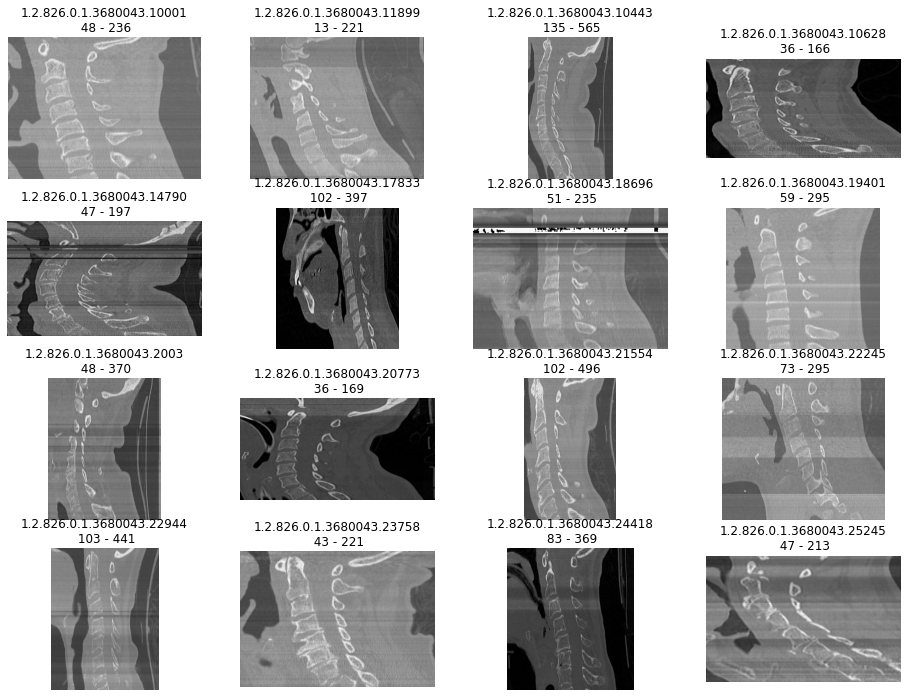

In [38]:
show_cases(indices)

# Image Count: Before & After

In [39]:
num_images_before = fndf.shape[0]

dff = final_df.copy()
dff['total'] = dff.bottom_range - dff.top_range + 1
num_images_after = dff.total.sum()

num_images_before, num_images_after, num_images_before - num_images_after

(711601, 477661, 233940)

In [40]:
num_images_after/num_images_before

0.6712483540635834